# Intra-Cluster Light (ICL) profiles analysis in the Dark Energy Survey (DES)




In [1]:
import healpy as hp
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from healpy.rotator import Rotator
import kmeans_radec
from kmeans_radec import KMeans, kmeans_sample
from astropy.table import Table
import os
import os.path
import configparser
import sys
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

/home/hillysson/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
ini_file= 'redmapper_y1.ini'
config = configparser.ConfigParser()
inifile = config.read(ini_file)
input_dir_rdmp=config.get('input', 'input_dir')
catalog=config.get('input', 'catalog_file')
flag_files_rdmp=[ii.strip() for ii in config.get('input', 'flag_files').split(',')]
save_dir_rdmp=config.get('output', 'save_dir')
grid_output_dir_rdmp=config.get('grid_output', 'save_dir')
rdmp=pyfits.open(catalog)[1].data
flags_rdmp=np.zeros(len(rdmp))+1
indices_rdmp=np.arange(len(rdmp))

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             r'$\lambda$ = [60;$\infty$)']
richness_dir = ['richness_20_30/',
                'richness_30_45/',
                'richness_45_60/',
                'richness_60_beyond/']

# getting indices in the flag files
for file_flag in flag_files_rdmp:
    if os.path.isfile(file_flag):
        flag_dat=np.loadtxt(file_flag, dtype=[('index', int), ('flag', int)], skiprows=1)
        flag=flag_dat['flag']
        if len(flag) == len(flags_rdmp):
            flags_rdmp=flags_rdmp*flag

ind1, =np.where( (flags_rdmp > 0.5) & (flags_rdmp<1.5) & (rdmp['lambda_chisq']>= 20) & (rdmp['lambda_chisq'] < 30))
print(len(ind1), len(indices_rdmp))
ind2, =np.where( (flags_rdmp > 0.5) & (flags_rdmp<1.5) & (rdmp['lambda_chisq']>= 30) & (rdmp['lambda_chisq'] < 45))
print(len(ind2), len(indices_rdmp))
ind3, =np.where( (flags_rdmp > 0.5) & (flags_rdmp<1.5) & (rdmp['lambda_chisq']>= 45) & (rdmp['lambda_chisq'] < 60))
print(len(ind3), len(indices_rdmp))
ind4, =np.where( (flags_rdmp > 0.5) & (flags_rdmp<1.5) & (rdmp['lambda_chisq']>= 60) & (rdmp['lambda_chisq'] < 40000000))
print(len(ind4), len(indices_rdmp))

307 7066
152 7066
52 7066
32 7066


In [3]:
'''
ind1, =np.where( (flags_rdmp > 0.5) & (flags_rdmp<1.5) & (rdmp['lambda_chisq']>= 20) & (rdmp['lambda_chisq'] < 30)&(rdmp['Z_LAMBDA']>=0.2)&(rdmp['Z_LAMBDA']<0.3))
print(len(ind1), len(indices_rdmp))
ind2, =np.where( (flags_rdmp > 0.5) & (flags_rdmp<1.5) & (rdmp['lambda_chisq']>= 30) & (rdmp['lambda_chisq'] < 50)&(rdmp['Z_LAMBDA']>=0.2)&(rdmp['Z_LAMBDA']<0.3))
print(len(ind2), len(indices_rdmp))
ind3, =np.where( (flags_rdmp > 0.5) & (flags_rdmp<1.5) & (rdmp['lambda_chisq']>= 50) & (rdmp['lambda_chisq'] <  40000000)&(rdmp['Z_LAMBDA']>=0.2)&(rdmp['Z_LAMBDA']<0.3))
print(len(ind3), len(indices_rdmp))
'''

204 7066
117 7066
36 7066


In [19]:
#inds = [ind1,ind2,ind3,ind4]
#for ij in range(4):
#    ngal_bins=ij
#    ind = inds[ngal_bins-1]
#    print('z = '+str(np.mean(rdmp['Z'][ind])))
    
ngal_bins=1
inds = [ind1,ind2,ind3,ind4]
ind = inds[ngal_bins-1]
Ncl = len(ind)
richness_dir = ['richness_20_30/',
                'richness_30_45/',
                'richness_45_60/',
                'richness_60_beyond/']

numflag = 0
flag = ['', '_scaled', '_z19'][numflag]

####
second_path_rdmp = 'rdmp6417_output_mask35_v2/'
dat_type=[('distance', float), ('mean', float), ('median', float)]

to_be_removed = []

for jji, jj in enumerate(ind):  # jji is an index from 0 to 356
                                # jj is the cluster id
    
    #file_jj_g=input_dir_rdmp+second_path_rdmp+'object_%i/profile_%i_g.txt'%(jj,jj)
    file_jj_r=input_dir_rdmp+second_path_rdmp+'object_%i/profile_%i_r.txt'%(jj,jj)
    #if os.path.isfile(file_jj_g) and os.path.isfile(file_jj_r):
    if os.path.isfile(file_jj_r):
        continue
    else:
        print('there is no profile for the cluster  with index '+str(jj))
        to_be_removed.append(jj)

        
to_be_removed = to_be_removed + [6, 36, 71, 172,228, 255, 345,435,
                                618, 640,724, 735, 759, 1157, 1204,
                                1239, 1272, 1293, 1415, 1571,
                                1611, 1699, 1723, 1777, 1838,
                                1871, 1971, 2298, 2363, 2376,
                                2452, 2520, 2630, 2688, 2764,
                                2807, 3068, 3463, 3496, 3660,
                                4035, 4103, 4330, 4355, 4549,
                                4718, 4787, 4805, 4856, 5004,
                                5832, 6031, 6128] 

# remove the clusters indices that there is no profiles
for rem in to_be_removed:
    if rem in ind:
        ind = np.delete(ind, list(ind).index(rem))
    
print('total number of clusters to use: '+str(len(ind)))
        

total number of clusters to use: 30


In [20]:
flag

'_z19'

In [21]:
####
#x = new_profile['# xx']
#y = new_profile['r_mean'] 

dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
dat_type=[('distance', float), ('mean', float), ('median', float)]
data_temp=Table.read(dir_sub+'subtracted_profile_%i%s.txt'%(ind[1],flag), format='ascii')
ncluster=len(ind)
nbins=len(data_temp['# xx'])#20#399
yy_r=np.zeros([nbins, ncluster])+999999
xx=data_temp['# xx']
ct=0

for jji, jj in enumerate(ind):  # jji is an index from 0 to 356
                                # jj is the cluster id

    file_jj=dir_sub+'subtracted_profile_%i%s.txt'%(jj,flag)
    if os.path.isfile(file_jj):
        data_sub=Table.read(file_jj, format='ascii')
        
        if len(data_sub['# xx'])==nbins: # nbins: length of the profile, number of radius bins
            yy_r[:, jji]=data_sub['r_mean']
            ct=ct+1
        else:
            print(jji)


print('total number of clusters to use: '+str(ct))
        

total number of clusters to use: 30


In [22]:
## jacknife sampling
from astropy.io.fits import Column

# getting the center position of rdmp clusters
coord_rdmp=np.transpose( np.array([rdmp[ind]['ra'], rdmp[ind]['dec']]) )
ncen = 40

if os.path.isfile('centers.txt') == 0: #this is false, so the code is jumping this part
    km = kmeans_sample(coord_rdmp, ncen, maxiter=100, tol=1.0e-5)
    print("found centers:",km.centers)
    print("converged?",km.converged)
    np.savetxt('centers.txt', km.centers)
centers=np.loadtxt('centers.txt')

# find the rdmp cluster closest to the center of the region:
labels_rdmp=kmeans_radec.find_nearest(coord_rdmp, centers)
print(labels_rdmp)
print(str(len(labels_rdmp))+' clusters')
print('  ')


len_kmeans=centers.shape[0] # 40, number of regions
os.system('mkdir '+save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/')
dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
os.system('mkdir '+dir_ind)

c0=Column(name='Jacknife_index', format='K')
c1=Column(name='x_axis', format='%iE'%nbins)
c2=Column(name='mean', format='%iE'%nbins)
cols = pyfits.ColDefs([c0, c1, c2])
hdu = pyfits.BinTableHDU.from_columns(cols, nrows=len_kmeans)

for ii in range(len_kmeans): # binning in kmean regions
    
    # subtracting clusters that belong to this region
    ind_rdmp,=np.where( (labels_rdmp != ii) )    
    print('region %i:'%(ii))
    print(str(len(labels_rdmp)-len(ind_rdmp))+' cluster(s) were removed')
    print(str(len(ind_rdmp))+' cluster(s) were used')
    print('')
    
    yyrmean_ind=np.zeros(nbins)    
    for jj in range(nbins): # binning in radius        
        temp_r_mean =yy_r[jj, :]        
        ind_temp, =np.where((temp_r_mean < 30000) & (temp_r_mean >-30000) & \
                            (labels_rdmp != ii) )        
        arr=temp_r_mean[ind_temp]
        yyrmean_ind[jj]=np.mean(arr)
        
    hdu.data[ii]['Jacknife_index']=ii
    hdu.data[ii]['x_axis']=xx
    hdu.data[ii]['mean']=yyrmean_ind
    
if os.path.isfile(dir_ind+'jacknife_profile_r_proper_kpc%s.fits'%(flag)):
    os.remove(dir_ind+'jacknife_profile_r_proper_kpc%s.fits'%(flag))

hdu.writeto(dir_ind+'jacknife_profile_r_proper_kpc%s.fits'%(flag))



[18 15  0 26  4 17 30 31 15 37 10  1  6 38 21 12 21 19 26  7  1  0  0  9
 33 29 35 28 37 39]
30 clusters
  
region 0:
3 cluster(s) were removed
27 cluster(s) were used

region 1:
2 cluster(s) were removed
28 cluster(s) were used

region 2:
0 cluster(s) were removed
30 cluster(s) were used

region 3:
0 cluster(s) were removed
30 cluster(s) were used

region 4:
1 cluster(s) were removed
29 cluster(s) were used

region 5:
0 cluster(s) were removed
30 cluster(s) were used

region 6:
1 cluster(s) were removed
29 cluster(s) were used

region 7:
1 cluster(s) were removed
29 cluster(s) were used


/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in less
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater



region 8:
0 cluster(s) were removed
30 cluster(s) were used

region 9:
1 cluster(s) were removed
29 cluster(s) were used

region 10:
1 cluster(s) were removed
29 cluster(s) were used

region 11:
0 cluster(s) were removed
30 cluster(s) were used

region 12:
1 cluster(s) were removed
29 cluster(s) were used

region 13:
0 cluster(s) were removed
30 cluster(s) were used

region 14:
0 cluster(s) were removed
30 cluster(s) were used

region 15:
2 cluster(s) were removed
28 cluster(s) were used

region 16:
0 cluster(s) were removed
30 cluster(s) were used

region 17:
1 cluster(s) were removed
29 cluster(s) were used

region 18:
1 cluster(s) were removed
29 cluster(s) were used

region 19:
1 cluster(s) were removed
29 cluster(s) were used

region 20:
0 cluster(s) were removed
30 cluster(s) were used

region 21:
2 cluster(s) were removed
28 cluster(s) were used

region 22:
0 cluster(s) were removed
30 cluster(s) were used

region 23:
0 cluster(s) were removed
30 cluster(s) were used

region 24

In [23]:
def jacknife_statistics(dat1, dat2 = np.zeros(1), bkg = 0):

    njack, narray = dat1.shape

    if dat1.shape != dat2.shape:
        dat2 = np.zeros([njack, narray]) # alternatively dat2 is 0
        print('no second array, using 0')
    mean = np.zeros(narray); err = np.zeros(narray)
    err_factor = np.sqrt(njack-1)

    for ii in range(narray):
        #bkg = 0 # dat1[:, narray-1] - dat2[:, narray-1] # 0 for default
        mean[ii] = np.mean(dat1[:, ii] - dat2[:, ii] - bkg)
        err[ii] = np.std(dat1[:, ii] - dat2[:, ii] - bkg) * err_factor
        
    return mean, err

binrich=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]

rdmp_jack = pyfits.open(binrich+'jacknife_profile_r_proper_kpc%s.fits'%(flag))
mean_0, err_0 = jacknife_statistics(rdmp_jack[1].data['mean'])
xx_arr_0 = rdmp_jack[1].data['x_axis']
mask = xx_arr_0[0]>xx_arr_0[0][299]
ytemp_rdmp, =np.where((np.array(mean_0[mask]) < 300000) & (np.array(mean_0[mask]) >-300000))
y_non_nan = np.array(mean_0[mask])[ytemp_rdmp]
skyback = np.mean(y_non_nan)  

mean, err=jacknife_statistics(rdmp_jack[1].data['mean'], bkg = skyback)
xx_arr = rdmp_jack[1].data['x_axis']
yyfactor=1.0/(0.263*cosmo.kpc_proper_per_arcmin(0.275).value/60.0)**2
np.savetxt(dir_ind+'sub_moments%s.fits'%(flag), np.array([xx_arr[0], mean_0*yyfactor, err_0*yyfactor]).T, fmt='%f', header='# # xx, means, std')   
#np.savetxt(dir_ind+'sub_moments.txt', np.array([xx_arr[0], mean*yyfactor, err*yyfactor]).T, fmt='%f', header='# # xx, means, std')   



no second array, using 0
no second array, using 0


In [24]:
'''
rdmp_jack = pyfits.open(binrich+'jacknife_profile_r_proper_kpc%s.fits'%(flag))
mea = rdmp_jack[1].data['mean']


fig = plt.figure(figsize=(7,7))  
plt.subplot(1,1,1)
ax = fig.add_subplot(1,1,1)
plt.xscale('log')
plt.grid(alpha=0.3)

for l in range(len(mea)):
    plt.plot(xx_arr_0[l], mea[l], '-', color='black', alpha=0.35, label='')
    

richness_dir = ['richness_20_30/',
                'richness_30_45/',
                'richness_45_60/',
                'richness_60_beyond/']
dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
r_red, mea_, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

mea = mea_
up = mea+std
low = mea-std
#plt.plot(r_red, mea, '-', lw=1.5,alpha=0.6,color='r',label='')
#plt.plot(r_red, up, '-', lw=1.5,alpha=0.6,color='b',label='')
#plt.plot(r_red, low, '-', lw=1.5,alpha=0.6,color='b',label='')
    
    
plt.yscale('log')
plt.ylabel('flux [kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [kpc]', fontsize=17)

plt.xlim(1.5, 3000)
#plt.ylim(-1., 1000)
plt.ylim(0.0001, 1000)
#plt.legend(bbox_to_anchor=(0.53, 0.9), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)
plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
       bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
       bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
'''


"\nrdmp_jack = pyfits.open(binrich+'jacknife_profile_r_proper_kpc%s.fits'%(flag))\nmea = rdmp_jack[1].data['mean']\n\n\nfig = plt.figure(figsize=(7,7))  \nplt.subplot(1,1,1)\nax = fig.add_subplot(1,1,1)\nplt.xscale('log')\nplt.grid(alpha=0.3)\n\nfor l in range(len(mea)):\n    plt.plot(xx_arr_0[l], mea[l], '-', color='black', alpha=0.35, label='')\n    \n\nrichness_dir = ['richness_20_30/',\n                'richness_30_45/',\n                'richness_45_60/',\n                'richness_60_beyond/']\ndir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]\njacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))\nr_red, mea_, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]\n\nmea = mea_\nup = mea+std\nlow = mea-std\n#plt.plot(r_red, mea, '-', lw=1.5,alpha=0.6,color='r',label='')\n#plt.plot(r_red, up, '-', lw=1.5,alpha=0.6,color='b',label='')\n#plt.plot(r_red, low, '-', lw=1.5,alpha=0.6,color='b',label='')\n    \n    \nplt.y

no second array, using 0


No handles with labels found to put in legend.


no second array, using 0


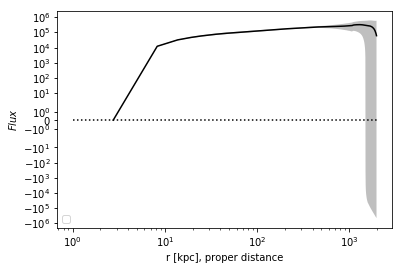

In [25]:
def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    njack, narray = dat1.shape
    if dat1.shape != dat2.shape:
        dat2 = np.zeros([njack, narray]) # alternatively dat2 is 0
        print('no second array, using 0')

    return_arr = np.zeros([njack, narray]) # alternatively dat2 is 0
    bkg = 0 # dat1[:, narray-1] - dat2[:, narray-1] # 0 for default
    dat=dat1-dat2-bkg
    for ii in range(njack):
        xx_temp=radius
        yy_temp=dat[ii]*xx_temp
        yy_temp=np.insert(yy_temp, 0, yy_temp[0])
        xx_temp=np.insert(xx_temp, 0, 0)
        for kk in range(narray):
            return_arr[ii, kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])*2.0*np.pi

    return return_arr

dat1=rdmp_jack[1].data['mean']
xx = rdmp_jack[1].data['x_axis']

integ_jack=integrate_flux(xx, dat1*yyfactor)
mean_int, err_int = jacknife_statistics(integ_jack)

z=zip(xx[0], mean_int, err_int);#np.savetxt('integrated'+filename, z, fmt='%f, %f, %f', header='# radius, integrated flux,uncertainty')
np.savetxt(dir_ind+'int_moments%s.fits'%(flag), np.array([xx_arr[0], mean_int, err_int]).T, fmt='%f', header='# xx, means, std')   


plt.fill_between(xx[0], (mean_int-err_int), (mean_int+err_int), facecolor='k', alpha=0.25)
plt.plot(xx[0], mean_int, color='k', label='')
#plt.plot(xx[0], mean_int*yyfactor, color='r', label='')


plt.xlabel('r [kpc], proper distance')
if flag == '_scaled':
    plt.xlabel('r / R$_{200m}$')
    plt.plot([0.001, 2], [0, 0], 'k:')
else:
    plt.plot([1, 2000], [0, 0], 'k:')
plt.ylabel(r'$Flux$')
plt.yscale('symlog');
plt.xscale('log');
plt.legend(loc=3)
plt.show()

no second array, using 0
no second array, using 0


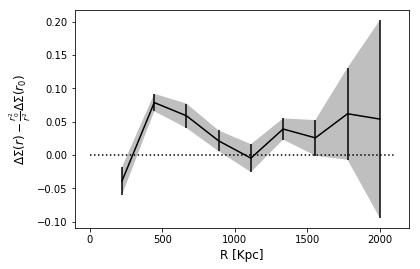

In [26]:
def first_delta_icl(rad, sigma, r0=200):   
    integr = integrate_flux(rad, sigma)/(2.*np.pi)  
    return (2/(rad**2)) * integr - sigma

def delta_deltax(rad, delta, r0=200):
    deltaxx = list(np.zeros(len(delta)))
    rmidxx = list(np.zeros(len(delta)))
    rmid = np.linspace(1,2001, 10)
    for kk in range(len(delta)):
        func=interp1d(rad[kk], delta[kk], fill_value = 'extrapolate')
        deltax = delta[kk] - func(r0)* (r0**2/rad[kk]**2)
        func2=interp1d(rad[kk], deltax, fill_value = 'extrapolate')
        deltaxx[kk]=func2(rmid)
        rmidxx[kk]=rmid
        
    return rmidxx, np.array(deltaxx)


from scipy.interpolate import interp1d

delta_jack=first_delta_icl(xx, dat1*yyfactor)
rmid, delta_icl2 = delta_deltax(xx, delta_jack, r0=200)
mean_delt, err_delt = jacknife_statistics(delta_icl2)

mask = rmid[0]>100
np.savetxt(dir_ind+'delta_moments%s.fits'%(flag), np.array([rmid[0][mask], mean_delt[mask], err_delt[mask]]).T, fmt='%f', header='# xx, means, std')   


plt.fill_between(rmid[0][mask], (mean_delt-err_delt)[mask], (mean_delt+err_delt)[mask], facecolor='k', alpha=0.25)
#plt.plot(rmid[0][mask], mean_delt[mask], color='k', label='')
plt.errorbar(rmid[0][mask], mean_delt[mask], yerr=np.array(err_delt[mask]), color='k',label='$\Delta \Sigma_{x}$')

plt.plot([1, 2100], [0, 0], 'k:')
plt.xlabel('R [Kpc]', fontsize=12)
plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=12)
#plt.xlim(200, 2100)
#plt.ylim(-0.1, 0.2)
plt.show()